In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys
sys.path.append("../src")
from utility import HCP,base
import time
import ot
import torch
import ot

import os
from pathlib import Path

In [2]:
r = np.random.RandomState(42)

def im2mat(img):
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))

def mat2im(X, shape):
    return X.reshape(shape)

def minmax(img):
    return np.clip(img, 0, 1)

# Green_Forest color transfer

In [3]:
I2 = pl.imread('figure/forest_road.jpg').astype(np.float64) / 256
I1 = pl.imread('figure/green_forest.jpg').astype(np.float64) / 256

X1 = im2mat(I1)
X2 = im2mat(I2)
ori_dat = X1
des_dat = X2

N = ori_dat.shape[0]
a, b = np.ones((N,)) / N, np.ones((N,)) / N

In [4]:
# training samples
nb = 1000
idx1 = r.randint(ori_dat.shape[0], size=(nb,))
idx2 = r.randint(des_dat.shape[0], size=(nb,))

Xs = ori_dat[idx1, :]
Xt = des_dat[idx2, :]

In [5]:
t0 = time.time()
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(42)

x1_torch = torch.tensor(ori_dat).to(device=device).requires_grad_(True)
s_des_dat = des_dat[np.random.choice(des_dat.shape[0],ori_dat.shape[0]),:]
x2_torch = torch.tensor(s_des_dat).to(device=device)


lr = 5e4
nb_iter_max = 30

x_all_sw = np.zeros((nb_iter_max, ori_dat.shape[0], 3))

# generator for random permutations
gen = torch.Generator(device=device)
gen.manual_seed(42)

for i in range(nb_iter_max):

    loss = ot.sliced_wasserstein_distance(x1_torch, x2_torch, n_projections=10, seed=gen)
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = x1_torch.grad
        x1_torch -= grad * lr / (1 + i / 5e1)  # step
        x1_torch.grad.zero_()
        x_all_sw[i, :, :] = x1_torch.clone().detach().cpu().numpy()
    
xb = x1_torch.clone().detach().cpu().numpy()
Image_sw = minmax(mat2im(xb, I1.shape))
t_sw = time.time()-t0
print('Time is ', t_sw, ' seconds.')

Time is  45.170899868011475  seconds.


In [6]:
t0 = time.time()
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(42)

x1_torch = torch.tensor(ori_dat).to(device=device).requires_grad_(True)
s_des_dat = des_dat[np.random.choice(des_dat.shape[0],ori_dat.shape[0]),:]
x2_torch = torch.tensor(s_des_dat).to(device=device)

x2o = base.hilbert_order(s_des_dat.T)

lr = 5e4
nb_iter_max = 30

x_all_hcp = np.zeros((nb_iter_max, ori_dat.shape[0], 3))


for i in range(nb_iter_max):

    x1n = x1_torch.cpu().detach().numpy()
    x1o = base.hilbert_order(x1n.T)

    loss = torch.mean(torch.pow((x1_torch[x1o,:]-x2_torch[x2o,:]),2))*3
    loss = torch.sqrt(loss)
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = x1_torch.grad
        x1_torch -= grad * lr / (1 + i / 5e1)  # step
        x1_torch.grad.zero_()
        x_all_hcp[i, :, :] = x1_torch.clone().detach().cpu().numpy()
        
xb = x1_torch.clone().detach().cpu().numpy()
Image_hcp = minmax(mat2im(xb, I1.shape))
t_hcp = time.time()-t0
print('Time is ', t_hcp, ' seconds.')

Time is  46.459595680236816  seconds.


# Forest_road color transfer

In [7]:
t0 = time.time()
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(42)

x1_torch = torch.tensor(des_dat).to(device=device).requires_grad_(True)
s_ori_dat = ori_dat[np.random.choice(ori_dat.shape[0],des_dat.shape[0]),:]
x2_torch = torch.tensor(s_ori_dat).to(device=device)


lr = 5e4
nb_iter_max = 30

x_all_sw2 = np.zeros((nb_iter_max, des_dat.shape[0], 3))

# generator for random permutations
gen = torch.Generator(device=device)
gen.manual_seed(42)

for i in range(nb_iter_max):

    loss = ot.sliced_wasserstein_distance(x1_torch, x2_torch, n_projections=10, seed=gen)
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = x1_torch.grad
        x1_torch -= grad * lr / (1 + i / 5e1)  # step
        x1_torch.grad.zero_()
        x_all_sw2[i, :, :] = x1_torch.clone().detach().cpu().numpy()
    
xb = x1_torch.clone().detach().cpu().numpy()
Image_sw2 = minmax(mat2im(xb, I2.shape))
t_sw = time.time()-t0
print('Time is ', t_sw, ' seconds.')

Time is  45.59049987792969  seconds.


In [8]:
t0 = time.time()
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(42)

x1_torch = torch.tensor(des_dat).to(device=device).requires_grad_(True)
s_ori_dat = ori_dat[np.random.choice(ori_dat.shape[0],des_dat.shape[0]),:]
x2_torch = torch.tensor(s_ori_dat).to(device=device)

x2o = base.hilbert_order(s_ori_dat.T)

lr = 5e4
nb_iter_max = 30

x_all_hcp2 = np.zeros((nb_iter_max, des_dat.shape[0], 3))


for i in range(nb_iter_max):

    x1n = x1_torch.cpu().detach().numpy()
    x1o = base.hilbert_order(x1n.T)

    loss = torch.mean(torch.pow((x1_torch[x1o,:]-x2_torch[x2o,:]),2))*3
    loss = torch.sqrt(loss)
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = x1_torch.grad
        x1_torch -= grad * lr / (1 + i / 5e1)  # step
        x1_torch.grad.zero_()
        x_all_hcp2[i, :, :] = x1_torch.clone().detach().cpu().numpy()
        
xb = x1_torch.clone().detach().cpu().numpy()
Image_hcp2 = minmax(mat2im(xb, I2.shape))
t_hcp = time.time()-t0
print('Time is ', t_hcp, ' seconds.')

Time is  52.52142262458801  seconds.


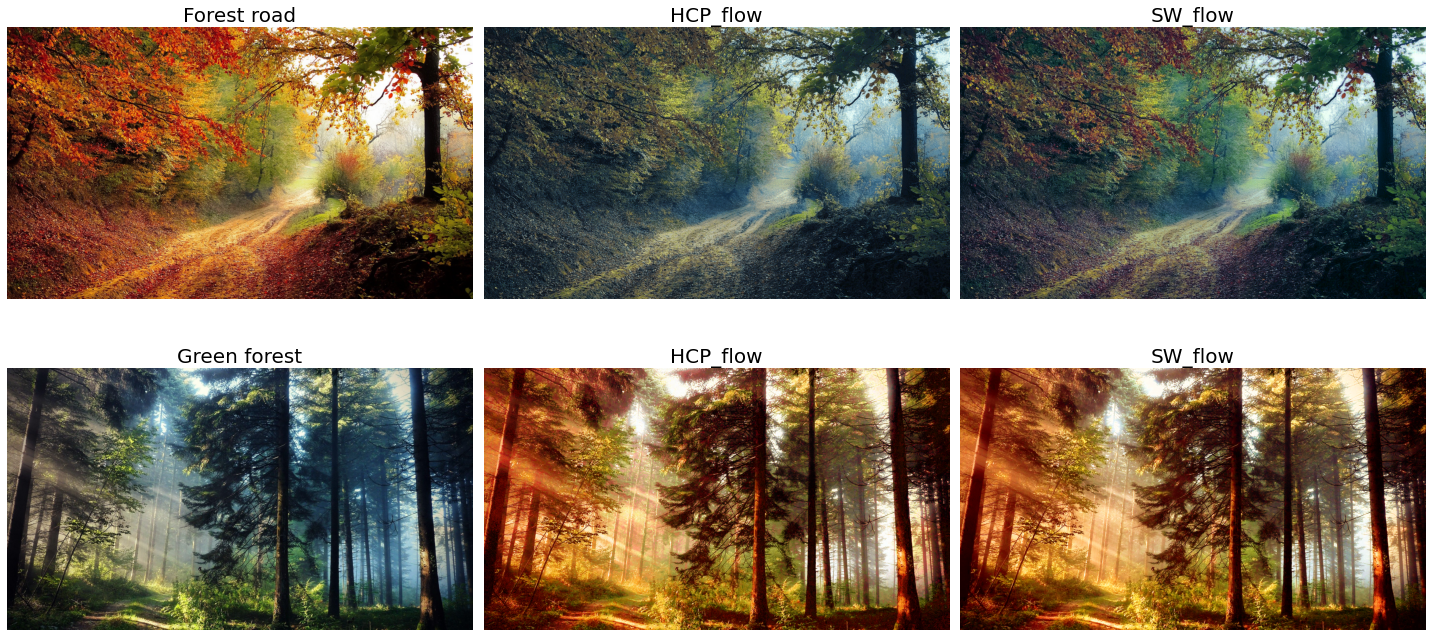

In [17]:
pl.figure(2, figsize=(20, 10))

pl.subplot(2, 3, 1)
pl.imshow(I2)
pl.axis('off')
pl.title('Forest road',fontsize=20)

pl.subplot(2, 3, 4)
pl.imshow(I1)
pl.axis('off')
pl.title('Green forest',fontsize=20)

pl.subplot(2, 3, 2)
pl.imshow(Image_hcp2)
pl.axis('off')
pl.title('HCP_flow',fontsize=20)

pl.subplot(2, 3, 5)
pl.imshow(Image_hcp)
pl.axis('off')
pl.title('HCP_flow',fontsize=20)

pl.subplot(2, 3, 3)
pl.imshow(Image_sw2)
pl.axis('off')
pl.title('SW_flow',fontsize=20)

pl.subplot(2, 3, 6)
pl.imshow(Image_sw)
pl.axis('off')
pl.title('SW_flow',fontsize=20)

pl.tight_layout()
pl.savefig('Results/color1.png')
pl.show()


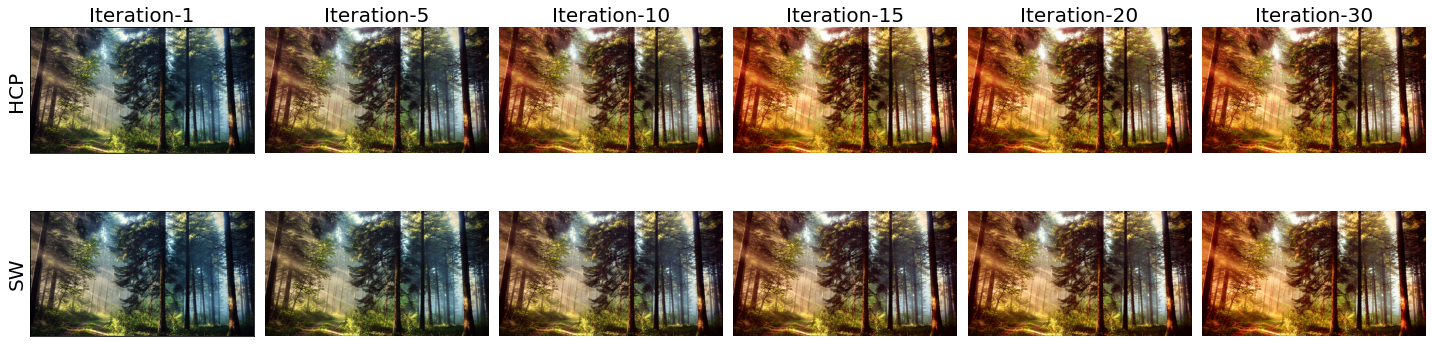

In [15]:
iterations = [1,5,10,15,20,30]
ii = 0
pl.figure(2, figsize=(20, 6))

for i in iterations:
    ii += 1
    pl.subplot(2, 6, ii)
    Image_i = minmax(mat2im(x_all_hcp[i-1], I1.shape))
    pl.imshow(Image_i)
    # pl.axis('off')
    pl.title('Iteration-'+str(i),fontsize=20)
    if ii==1:
        pl.ylabel('HCP',fontsize=20)
        pl.xticks([])
        pl.yticks([])
    else:
        pl.axis('off')


    pl.subplot(2, 6, ii+6)
    Image_i = minmax(mat2im(x_all_sw[i-1], I1.shape))
    pl.imshow(Image_i)
    # pl.axis('off')
    if ii==1:
        pl.ylabel('SW',fontsize=20)
        pl.xticks([])
        pl.yticks([])
    else:
        pl.axis('off')
    
pl.tight_layout()
pl.savefig('Results/color2.png')
pl.show()

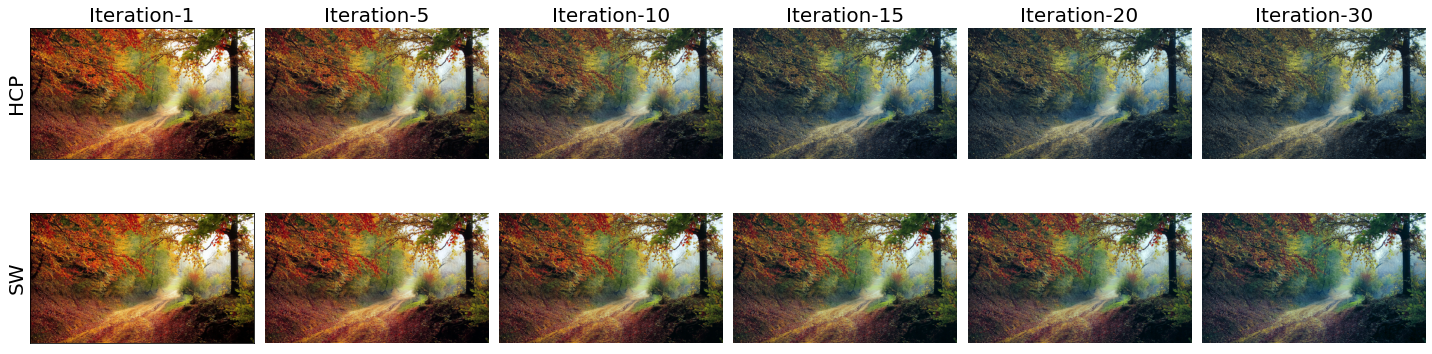

In [16]:
iterations = [1,5,10,15,20,30]
ii = 0
pl.figure(2, figsize=(20, 6))

for i in iterations:
    ii += 1
    pl.subplot(2, 6, ii)
    Image_i = minmax(mat2im(x_all_hcp2[i-1], I2.shape))
    pl.imshow(Image_i)
    # pl.axis('off')
    pl.title('Iteration-'+str(i),fontsize=20)
    if ii==1:
        pl.ylabel('HCP',fontsize=20)
        pl.xticks([])
        pl.yticks([])
    else:
        pl.axis('off')


    pl.subplot(2, 6, ii+6)
    Image_i = minmax(mat2im(x_all_sw2[i-1], I2.shape))
    pl.imshow(Image_i)
    # pl.axis('off')
    if ii==1:
        pl.ylabel('SW',fontsize=20)
        pl.xticks([])
        pl.yticks([])
    else:
        pl.axis('off')
    
pl.tight_layout()
pl.savefig('Results/color3.png')
pl.show()